## Second Movement: Periodic Defender with CVE Data

In [10]:
print("""This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports""")

This Cell is necessary or else my IDE will start running cells simultaneously which
      then leads to issues with unfinished imports


In [11]:
# Import required libraries
import os
import logging
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## New Stuff

In [12]:
# Toggle to control execution mode
# True = standard calculation, False = includes 0 day exploit calculations (creates a separate file)
RUN_BASELINE_ONLY = False  

In [13]:
# Define experiment name as a variable for easy modification
experiment_name = "experiment_3"

In [14]:
# Set up main logger (original)
log_path = os.path.join(os.getcwd(), f'{experiment_name}.log')
if os.path.exists(log_path):
    os.remove(log_path)
logger = logging.getLogger()
handler = logging.FileHandler(log_path, mode='w')
handler.setFormatter(logging.Formatter('%(message)s'))
logger.addHandler(handler)
logger.setLevel(logging.INFO)
logger.info(f'[1] "{experiment_name}.log"')
logger.info(f'[1] "{datetime.now().strftime("%a %b %d %H:%M:%S %Y")}"')

# Set up subgraph logger if not RUN_BASELINE_ONLY:
if not RUN_BASELINE_ONLY:
    subgraph_log_path = os.path.join(os.getcwd(), f'sub_{experiment_name}.log')
    if os.path.exists(subgraph_log_path):
        os.remove(subgraph_log_path)
    subgraph_handler = logging.FileHandler(subgraph_log_path, mode='w')
    subgraph_handler.setFormatter(logging.Formatter('%(message)s'))
    # Don't add to logger yet

# Function to switch between loggers
def switch_logger(use_subgraph_logger=False):
    # Remove all handlers
    for hdlr in logger.handlers[:]:
        logger.removeHandler(hdlr)
        
    # Add appropriate handler
    if use_subgraph_logger:
        logger.addHandler(subgraph_handler)
        logger.info(f'[1] "sub_{experiment_name}.log"')
        logger.info(f'[1] "{datetime.now().strftime("%a %b %d %H:%M:%S %Y")}"')
    else:
        logger.addHandler(handler)

In [ ]:
# Global configuration
# This is the default weight value we will insert any time we we 
# need to insert a weight value for a trivial edge in the graph
# Why 0 ?  Because we have "hardness = exnp(-w)" so we get hardness = 1 for w = 0
# hardness = 1 means that edge is trivial to traverse
DEFAULT_WEIGHT_VALUE = 0  

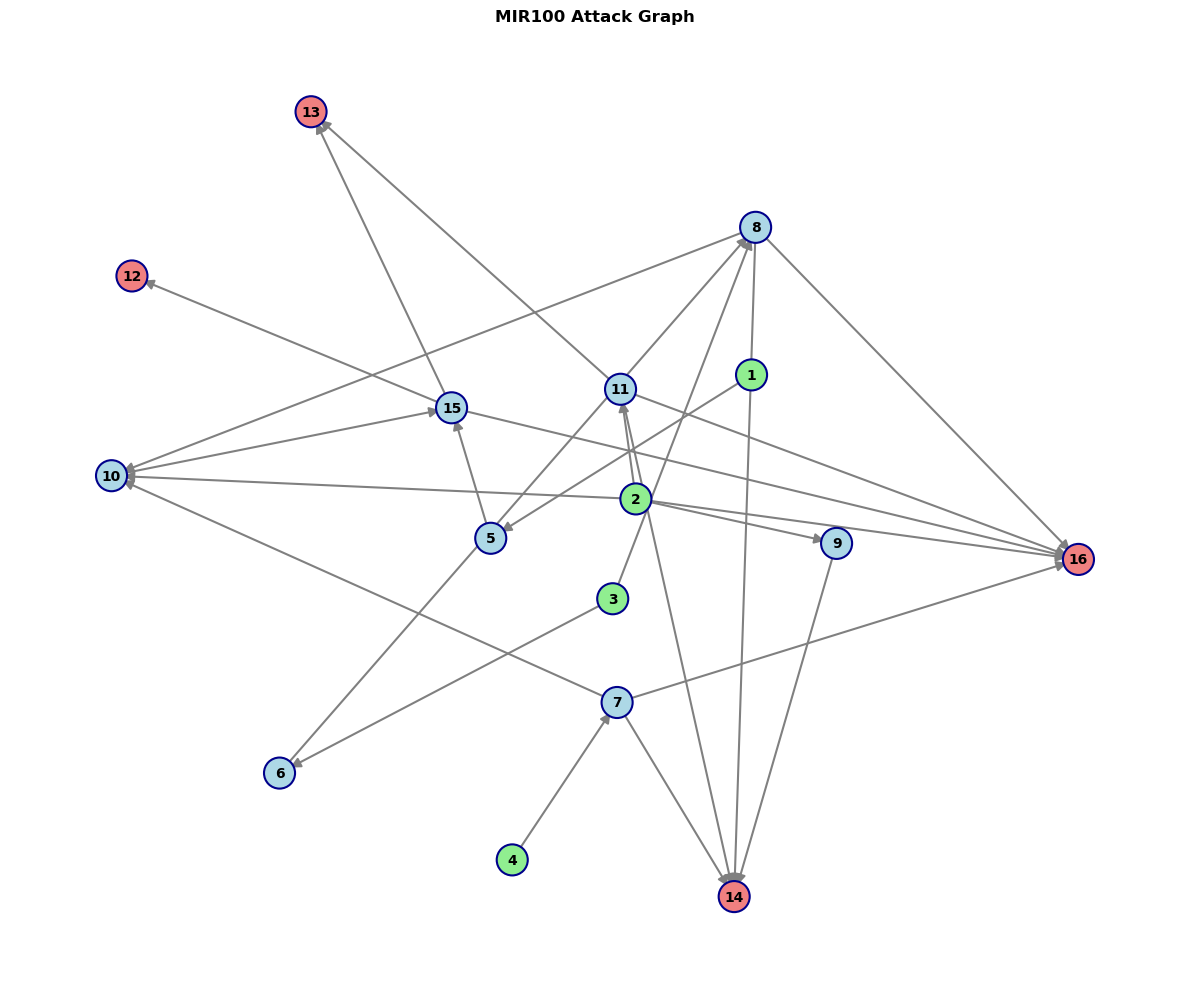

In [16]:
%run attack_graph_MIR100.ipynb

### Create Subgraphs

++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [5, 9]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets in subgraph: [12, 13, 14, 16]
Removing 1 unreachable nodes: {1}
++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [4, 1]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets in subgraph: [12, 13, 14, 16]
Removing 0 unreachable nodes: set()
++++++++++++++++++++++++++++++++++++++++
Start dropping & cleanup for the next subgraph here
Identified 4 target nodes: [12, 13, 14, 16]
Dropping 2 nodes: [8, 6]
Original graph had 16 nodes, subgraph has 14 nodes
Original legitimate targets: [12, 13, 14, 16]
Remaining legitimate targets in sub

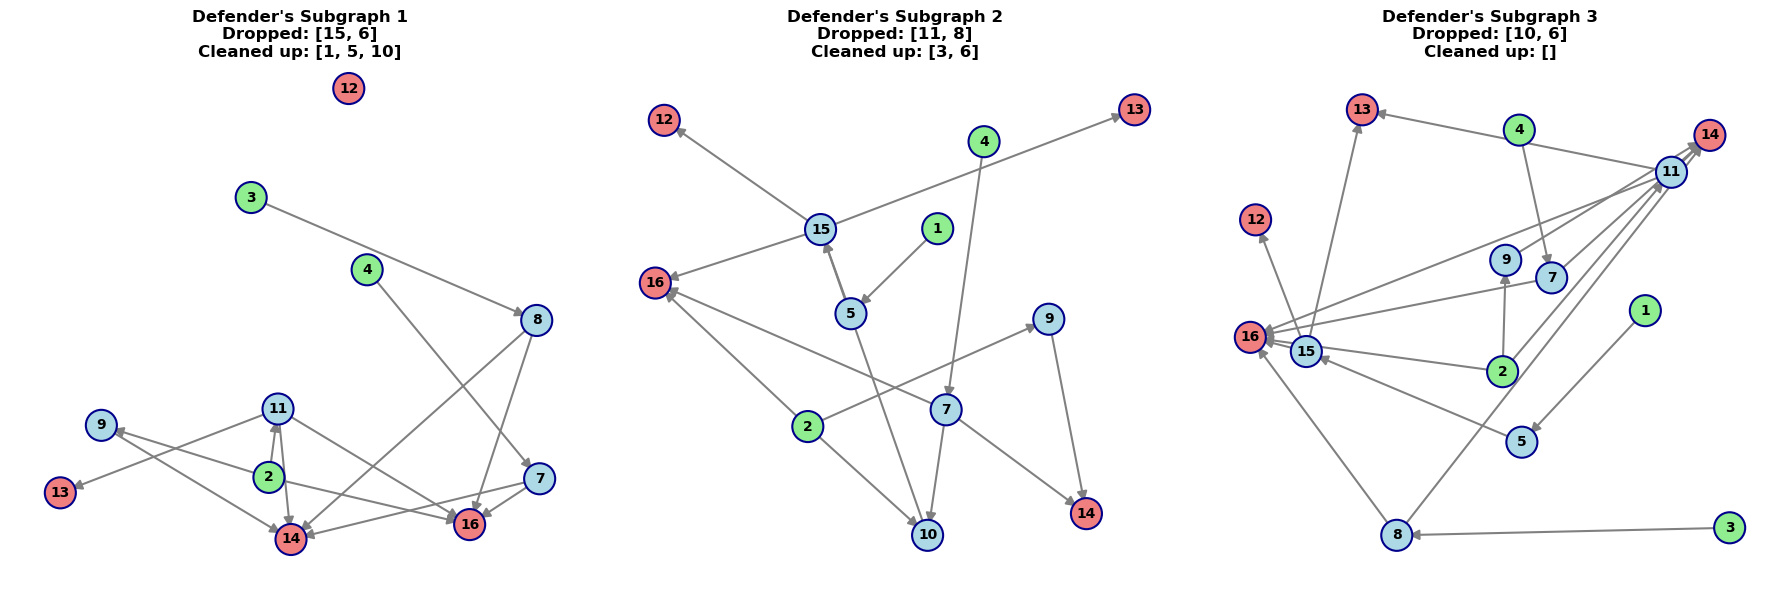

create subsgraph for defender concluded


In [17]:
%run create_subgraphs.ipynb

## Old Stuff

### Exploit-Dependent Probability Distribution Explanations
#### Base Formula
This distribution models the probability of completing exactly n exploits and failing on the (n+1)-st in a series of exploits with varying difficulty:
\begin{equation}
f_N(n) = (1 - q(e_{n+1})) \cdot \prod_{k=1}^{n} q(e_k)
\end{equation}
Where $q(e_k)$ is the probability of successfully executing exploit $e_k$ within a unit of time.

#### Definition of "q(e)" in this Specific Case
In the code, exploit success probability is defined as:
\begin{equation}
q(e) = e^{-weight(e)}
\end{equation}
where $weight(e)$ represents the difficulty/complexity of the exploit derived from CVE information.

This corresponds to formula (11) in the paper, where $q(e_k)$ represents the probability of success for exploit $k$.

#### Basic Explanation
This distribution models attacker behavior with periodic defender checks but varying exploit difficulties:

- Each edge (exploit) has a difficulty value derived from CVE data
- Higher edge weights → lower success probability (more difficult exploit)
- Lower edge weights → higher success probability (easier exploit)
- Attacker movement depends on sequential success probabilities along a path
- defense_rate not used since checks happen at known intervals
- attack_rate not needed since progress is determined by exploit difficulties

Key insight: Unlike the Poisson model where all steps have equal difficulty, this model accounts for real-world differences in exploit complexity.

This fits our intuition: When some exploits are harder than others, attackers must overcome varying challenges along their path, creating natural "choke points" that defenders can target.

### Run the Code

In [18]:
attack_rate_list = [0]   
defense_rate_list = [0]  

In [19]:
def random_steps(route, attack_rate=None, defense_rate=None, graph=None):
    """
    Calculates probabilities for attacker movement along route.
    Returns probability distribution over possible ending nodes.
    """

    # Part 1: Extract hardness values from all edges and append them
    # into one numpy array
    # Calculate hardness values for each edge 
    hardness = []
    for i in range(len(route) - 1):
        start_node = route[i]
        end_node = route[i + 1]
        
        # Initialize variables for max weight loop
        weights = []
        # Collect all weights for max
        for edge in graph[start_node][end_node].values():
            weights.append(edge.get('weight', DEFAULT_WEIGHT_VALUE))
        # Get maximum weight
        max_weight = max(weights) if weights else DEFAULT_WEIGHT_VALUE
        
        # Initialize variables for min weight loop
        min_weights = []
        # Collect all weights for min
        for edge in graph[start_node][end_node].values():
            min_weights.append(edge.get('weight', DEFAULT_WEIGHT_VALUE))
        # Get minimum weight
        min_weight = min(min_weights) if min_weights else DEFAULT_WEIGHT_VALUE
            
        # Convert weights to probabilities
        # We could take max_weight or min_weight here
        # hardness.append(np.exp(-max_weight))

        # Important: We use min_weight here because of the following reason:
        # Since the formula to calculate hardness in R is hardness = exp(-weight)
        # taking the minimum weight will give us the maximum hardness
        # which translates to the path being EASIEST to traverse.
        # Yes hardness of 1 means path is trivial, hardness 0 means path is impossible
        hardness.append(np.exp(-min_weight))

    
    
    hardness = np.array(hardness)

    # print(f'Hardness: {hardness}')

    
    ## Part 2: Based on the extracted hardness values
    ## Calculate Movement Probabilities

    # We calculate two things:
    # 1. Probability of reaching each node (accumulating hardness along the way)
    # Example: if hardness = [0.8, 0.6, 0.4]
    # Then cumprod gives us: [0.8, 0.8*0.6, 0.8*0.6*0.4]
    # Final cumulative_probs = [1.0, 0.8, 0.48, 0.192]
    cumulative_probs = np.concatenate(([1.0], np.cumprod(hardness)))

    # 2. Probability of stopping at each node (based on the next edge's hardness)
    stop_probs = np.concatenate((1 - hardness, [1.0]))

    ## Part 3: Generate Final Distribution
    # Combine reaching and stopping probabilities to get probability of stopping at each node
    # Example calculation with above values:
    # Node0: 1.0 * 0.2 = 0.2    (20% chance of stopping at start)
    # Node1: 0.8 * 0.4 = 0.32   (32% chance of stopping at Node1)
    # Node2: 0.48 * 0.6 = 0.288 (28.8% chance of stopping at Node2)
    # Node3: 0.192 * 1.0 = 0.192 (19.2% chance of reaching final node)
    pdf = cumulative_probs * stop_probs

    # Handle case where probabilities are essentially zero
    if pdf.sum() < 1e-15:
        pdf = np.full_like(pdf, 1e-7)

    # Normalize to ensure probabilities sum to 1
    # print(f"This is the final pdf that is returned in the end: {pdf / pdf.sum()}")
    return pdf / pdf.sum()

In [20]:
# %run ctr-core_simple.ipynb
%run exp_ctr-core.ipynb
main()

We start with the baseline graph calculation!

This is the Attacker Graph:
Nodes: [1, 5, 15, 12, 11, 13, 3, 6, 8, 4, 7, 2, 9, 10, 14, 16]
Total list of Edges with their weights:
1 -> 5 : 2.1958405355640576
5 -> 15 : 2.1958405355640576
15 -> 12 : 0.7489220813074156
15 -> 13 : 0.7489220813074156
15 -> 16 : 0.7489220813074156
11 -> 13 : 1.064439873679208
11 -> 14 : 0.7489220813074156
11 -> 16 : 0.0
3 -> 6 : 1.064439873679208
3 -> 8 : 0.7489220813074156
6 -> 8 : 0.0
8 -> 10 : 0.0
8 -> 14 : 0.0
8 -> 16 : 0.7489220813074156
4 -> 7 : 0.7489220813074156
7 -> 10 : 0.7489220813074156
7 -> 14 : 0.7489220813074156
7 -> 16 : 0.7489220813074156
2 -> 9 : 0.7489220813074156
2 -> 10 : 1.064439873679208
2 -> 11 : 0.7489220813074156
2 -> 16 : 1.064439873679208
9 -> 14 : 1.064439873679208
10 -> 15 : 0.0

After merging targets of attack graph:
Nodes: [1, 5, 15, 11, 3, 6, 8, 4, 7, 2, 9, 10, 0, 'c(12,13,14,16)']
Total list of Edges with their weights:
1 -> 5 (key=0) : 2.1958405355640576
5 -> 15 (key=0) : 2.1

In [21]:
with open(experiment_name+'.log', 'r') as f:
    print(f.read())

[1] "experiment_3.log"
[1] "Sun Mar 09 14:23:08 2025"



BASELINE RUN: BOTH ATTACKER AND DEFENDER HAVE FULL GRAPH KNOWLEDGE



++++++++++++++++++++++++++++++++

The virtual target nodeID is c(12,13,14,16)

attack rate =  0 , defense rate =  0 

	equilibrium for multiobjective security game (MOSG)

optimal defense strategy:
         prob.
1 0.000000e+00
10 0.000000e+00
11 2.720264e-01
15 1.852234e-01
2 0.000000e+00
3 0.000000e+00
4 0.000000e+00
5 0.000000e+00
6 0.000000e+00
7 0.000000e+00
8 5.427503e-01
9 0.000000e+00

worst case attack strategies per goal:
          1
1 0.0000000
2 0.1441309
3 0.3573620
4 0.0000000
5 0.0000000
6 0.0000000
7 0.0000000
8 0.0000000
9 0.0000000
10 0.0000000
11 0.4985072
[1] 0.089

Defender can keep attacker success below: 0.089
Attacker can guarantee success probability of: 0.089

